In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import math

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# read data
data = pd.read_csv(r'children anemia.csv')

## WRANGLING

In [4]:
data.head()

,Age in 5-year groups,Type of place of residence,Highest educational level,Wealth index combined,Births in last five years,Age of respondent at 1st birth,Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal),Anemia level,Have mosquito bed net for sleeping (from household questionnaire),Smokes cigarettes,Current marital status,Currently residing with husband/partner,When child put to breast,Had fever in last two weeks,Hemoglobin level adjusted for altitude (g/dl - 1 decimal),Anemia level.1,"Taking iron pills, sprinkles or syrup"
0,40-44,Urban,Higher,Richest,1,22,NaN,NaN,Yes,No,Living with partner,Staying elsewhere,Immediately,No,NaN,NaN,Yes
1,35-39,Urban,Higher,Richest,1,28,NaN,NaN,Yes,No,Married,Living with her,Hours: 1,No,NaN,NaN,No
2,25-29,Urban,Higher,Richest,1,26,NaN,NaN,No,No,Married,Living with her,Immediately,No,NaN,NaN,No
3,25-29,Urban,Secondary,Richest,1,25,95.0,Moderate,Yes,No,Married,Living with her,105.0,No,114.0,Not anemic,No
4,20-24,Urban,Secondary,Richest,1,21,NaN,NaN,Yes,No,No longer living together/separated,NaN,Immediately,No,NaN,NaN,No


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33924 entries, 0 to 33923
Data columns (total 17 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Age in 5-year groups                                                   33924 non-null  object 
 1   Type of place of residence                                             33924 non-null  object 
 2   Highest educational level                                              33924 non-null  object 
 3   Wealth index combined                                                  33924 non-null  object 
 4   Births in last five years                                              33924 non-null  int64  
 5   Age of respondent at 1st birth                                         33924 non-null  int64  
 6   Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)  13136 non-null 

In [6]:
data['Anemia level'].value_counts(dropna=False)

Anemia level
NaN           20788
Not anemic     5337
Moderate       3974
Mild           3594
Severe          231
Name: count, dtype: int64

In [7]:
data['Anemia level'].fillna(data['Anemia level.1'], inplace=True)

<Axes: >

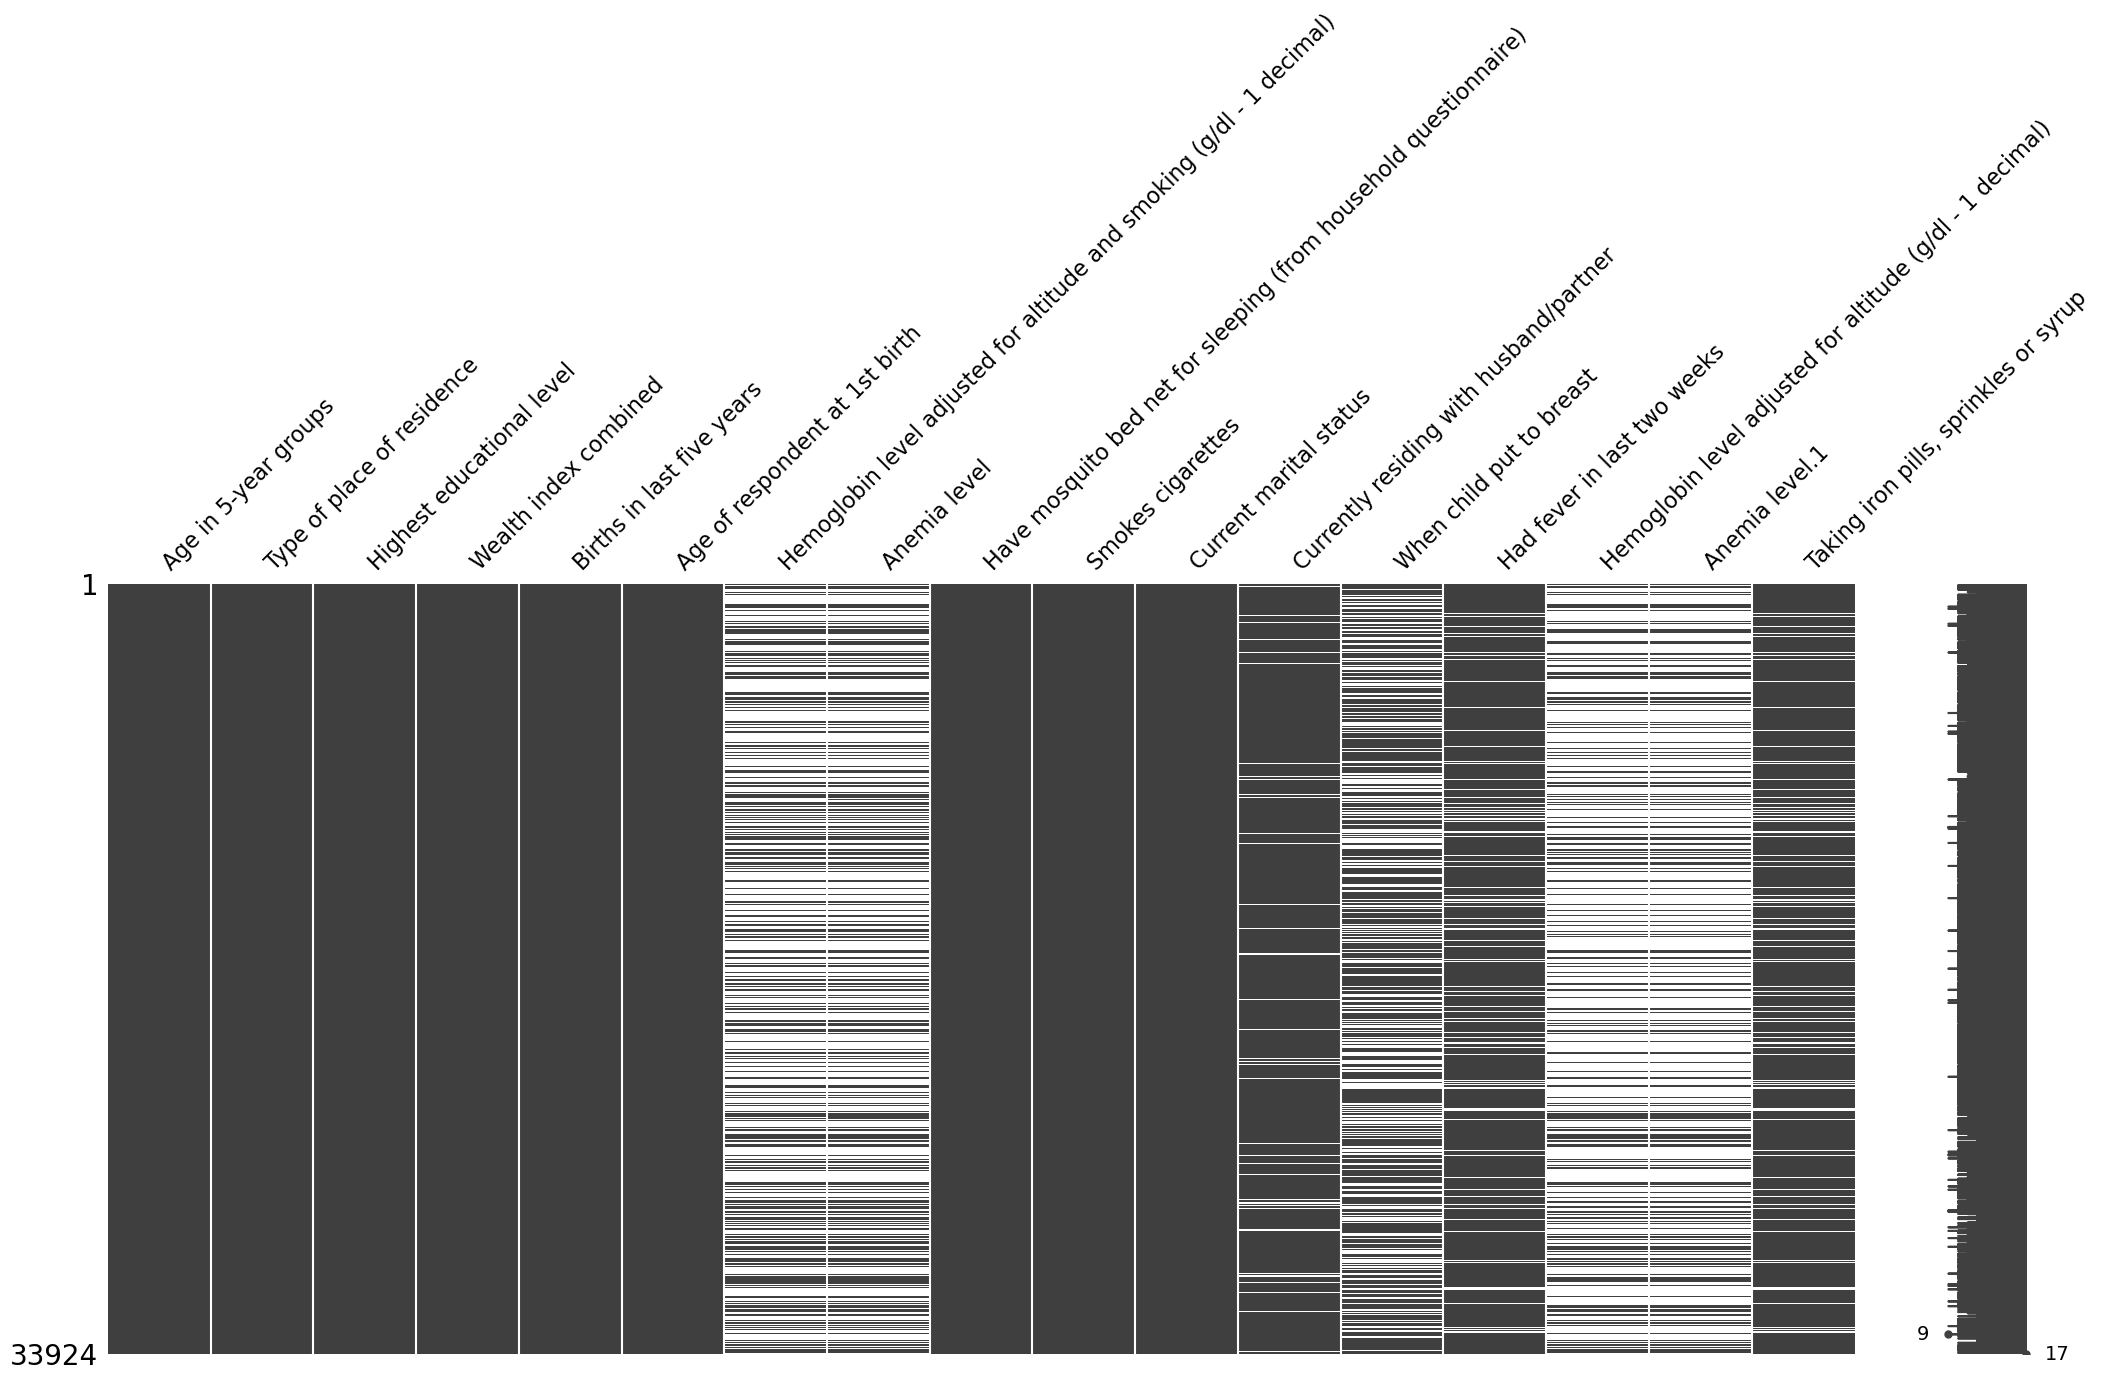

In [8]:
msno.matrix(data)

In [9]:
print('Percentage of missing data')
round(data.isna().sum().sort_values(ascending=False)/data.shape[0],2)

Percentage of missing data


Anemia level.1                                                           0.70
Hemoglobin level adjusted for altitude (g/dl - 1 decimal)                0.70
Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)    0.61
Anemia level                                                             0.61
When child put to breast                                                 0.38
Taking iron pills, sprinkles or syrup                                    0.09
Had fever in last two weeks                                              0.09
Currently residing with husband/partner                                  0.05
Current marital status                                                   0.00
Age in 5-year groups                                                     0.00
Smokes cigarettes                                                        0.00
Type of place of residence                                               0.00
Age of respondent at 1st birth                                  

In [10]:
def sep_num(num):
    """
    Function converts time values to minutes
    """
    try :
        if num.lower().startswith('immed'):
            return 1
        else:
            return int(float(num))//60
    except (ValueError,AttributeError):
        if num is not np.nan:
            res = num.split(':')
            if res[0].lower().startswith('hours'):
                return int(res[1])*60
            elif res[0].lower().startswith('day'):
                return int(res[1])*24*60 
        else:
            return num

In [11]:
data['When child put to breast'] = data['When child put to breast'].map(sep_num)

In [12]:
data.dtypes.value_counts()

object     12
float64     3
int64       2
Name: count, dtype: int64

In [13]:
data['Smokes cigarettes'].replace({'No':False,'Yes':True}, inplace=True)
data['Currently residing with husband/partner'].replace({'No':False,'Yes':True}, inplace=True)
data['Have mosquito bed net for sleeping (from household questionnaire)'].replace({'No':False,'Yes':True}, inplace=True)

In [14]:
data.head()

,Age in 5-year groups,Type of place of residence,Highest educational level,Wealth index combined,Births in last five years,Age of respondent at 1st birth,Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal),Anemia level,Have mosquito bed net for sleeping (from household questionnaire),Smokes cigarettes,Current marital status,Currently residing with husband/partner,When child put to breast,Had fever in last two weeks,Hemoglobin level adjusted for altitude (g/dl - 1 decimal),Anemia level.1,"Taking iron pills, sprinkles or syrup"
0,40-44,Urban,Higher,Richest,1,22,NaN,NaN,True,False,Living with partner,Staying elsewhere,1.0,No,NaN,NaN,Yes
1,35-39,Urban,Higher,Richest,1,28,NaN,NaN,True,False,Married,Living with her,60.0,No,NaN,NaN,No
2,25-29,Urban,Higher,Richest,1,26,NaN,NaN,False,False,Married,Living with her,1.0,No,NaN,NaN,No
3,25-29,Urban,Secondary,Richest,1,25,95.0,Moderate,True,False,Married,Living with her,1.0,No,114.0,Not anemic,No
4,20-24,Urban,Secondary,Richest,1,21,NaN,NaN,True,False,No longer living together/separated,NaN,1.0,No,NaN,NaN,No


In [15]:
# display number of uique elements in the numeric columns in the dataframe
data.select_dtypes(exclude='number').nunique().sort_values()

Type of place of residence                                           2
Have mosquito bed net for sleeping (from household questionnaire)    2
Smokes cigarettes                                                    2
Currently residing with husband/partner                              2
Had fever in last two weeks                                          3
Taking iron pills, sprinkles or syrup                                3
Highest educational level                                            4
Anemia level                                                         4
Anemia level.1                                                       4
Wealth index combined                                                5
Current marital status                                               6
Age in 5-year groups                                                 7
dtype: int64

In [16]:
data.rename(columns={'Type of place of residence':'residence type', 'Highest educational level':'education level',
                     'Smokes cigarettes':'smokes','Current marital status':'marital status',
                     'Taking iron pills, sprinkles or syrup':'takes supplements','Have mosquito bed net for sleeping (from household questionnaire)':'sleeps under mosquito net',
                     'Anemia level':'Anemia'},inplace=True)

In [17]:
# drop duplicate rows
data_non = data.drop_duplicates()

In [18]:
data_non.isna().sum().sort_values(ascending=False)

Anemia level.1                                                           17869
Hemoglobin level adjusted for altitude (g/dl - 1 decimal)                17869
Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)    15028
Anemia                                                                   14908
When child put to breast                                                  9636
takes supplements                                                         2591
Had fever in last two weeks                                               2591
Currently residing with husband/partner                                   1665
marital status                                                               0
Age in 5-year groups                                                         0
smokes                                                                       0
residence type                                                               0
Age of respondent at 1st birth                      

In [19]:
# fill all null values in the numerical data type category
data_non[data_non.select_dtypes('number').columns] = data_non.select_dtypes('number').apply(lambda x: x.fillna(round(np.mean(x),1)), axis=0)

In [20]:
data_non = data_non.dropna(axis=0)

In [21]:
# reset dataframe index
data_non.reset_index(drop = True, inplace= True)

In [22]:
# check if any value is missing
data_non.isnull().sum().sum()

0

In [23]:
# rename and get the average of the age groups
data_non['Age in 5-year groups'] = data_non["Age in 5-year groups"].apply(lambda x:sum(map(int,x.split('-')))/2).astype(int)
data_non.rename(columns= {'Age in 5-year groups':'Age average'}, inplace = True)

In [24]:
data_non['Anemia'] = data_non['Anemia'].apply(lambda x : False if x == 'Not anemic' else not False)

In [42]:
age_anemia_counts = pd.crosstab(index=data_non['Age of respondent at 1st birth'], columns=data_non['Anemia'])
age_anemia_counts

Anemia,False,True
Age of respondent at 1st birth,,
12,25,60
13,60,88
14,124,212
15,237,426
16,391,598
17,419,640
18,410,594
19,345,513
20,370,525


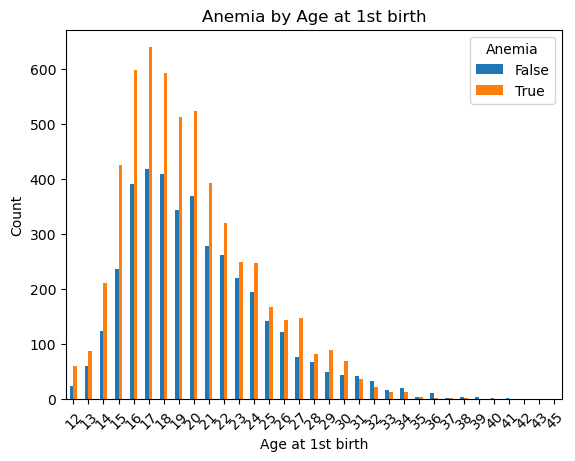

In [58]:
fig = plt.Figure((30,30))
age_anemia_counts.plot(kind='bar', stacked=False)
plt.xlabel('Age at 1st birth')
plt.ylabel('Count')
plt.title('Anemia by Age at 1st birth')
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='Births in last five years', ylabel='avg_child_year'>

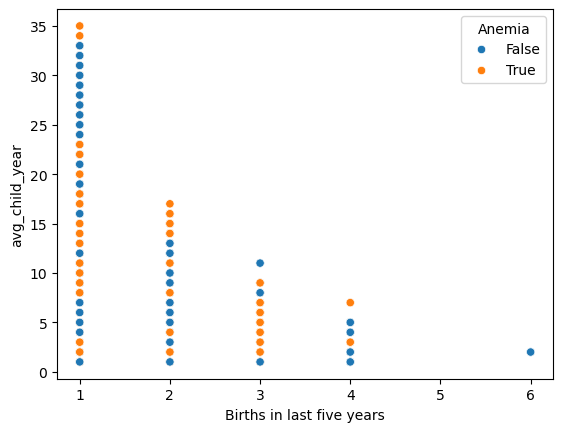

In [29]:
# difference of respondents age to the age at first birth
diff_age = np.abs(np.where(data_non['Age average'] - data_non['Age of respondent at 1st birth']==0, 1,(data_non['Age average'] - data_non['Age of respondent at 1st birth'])))
# checks for respondents rate of birth
data_non['avg_child_year'] = np.ceil(diff_age/data_non['Births in last five years']).astype(int)

sns.scatterplot(data_non, x='Births in last five years', y='avg_child_year', hue='Anemia')

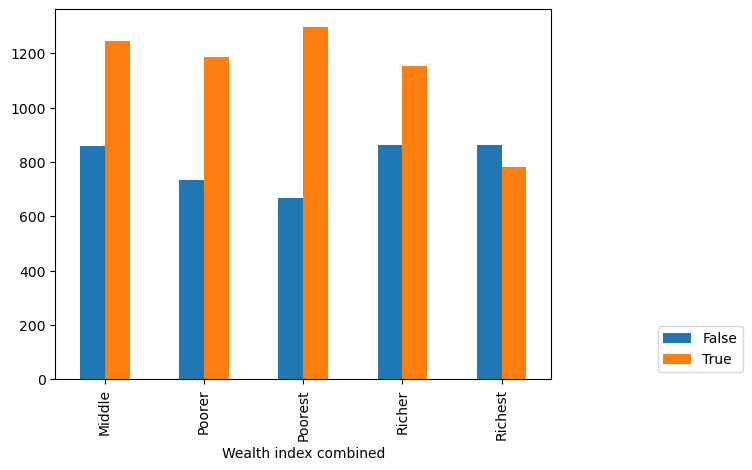

In [ ]:
wealth_n_condition = data_non[['Wealth index combined','Anemia']]
ax = wealth_n_condition.groupby(['Wealth index combined','Anemia']).size().unstack().plot(kind='bar',)
ax.legend(loc=4, bbox_to_anchor=(1.4,.0))

<Axes: xlabel='Wealth index combined', ylabel='avg_child_year'>

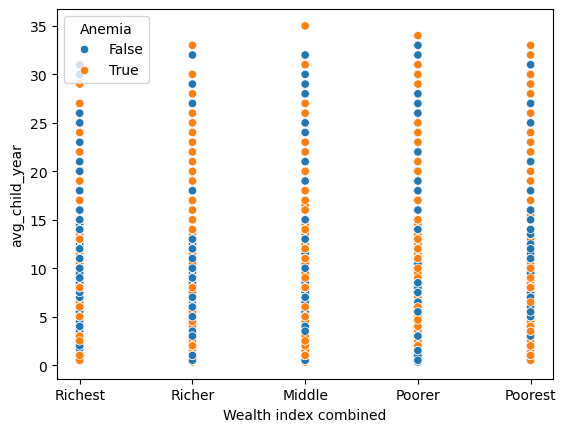

In [ ]:
sns.scatterplot(data_non,x='Wealth index combined',y='avg_child_year', hue='Anemia')

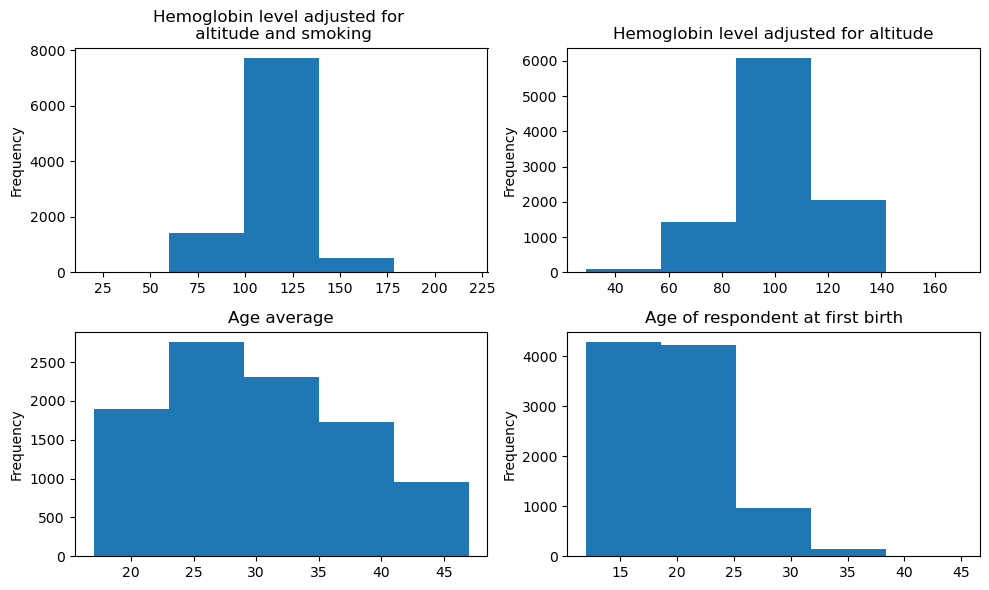

In [ ]:
# selected histogram plots
fig,axes = plt.subplots(2,2,figsize=(10,6))
axes = axes.flatten()

data_non['Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)'].plot.hist(bins = 5,ax = axes[0], title = f'Hemoglobin level adjusted for \n altitude and smoking')
data_non['Hemoglobin level adjusted for altitude (g/dl - 1 decimal)'].plot.hist(bins = 5, ax = axes[1], title = 'Hemoglobin level adjusted for altitude')
data_non['Age average'].plot.hist(bins=5, ax = axes[2], title = 'Age average')
data_non['Age of respondent at 1st birth'].plot.hist(bins = 5, ax = axes[3],title = "Age of respondent at first birth")
plt.tight_layout()

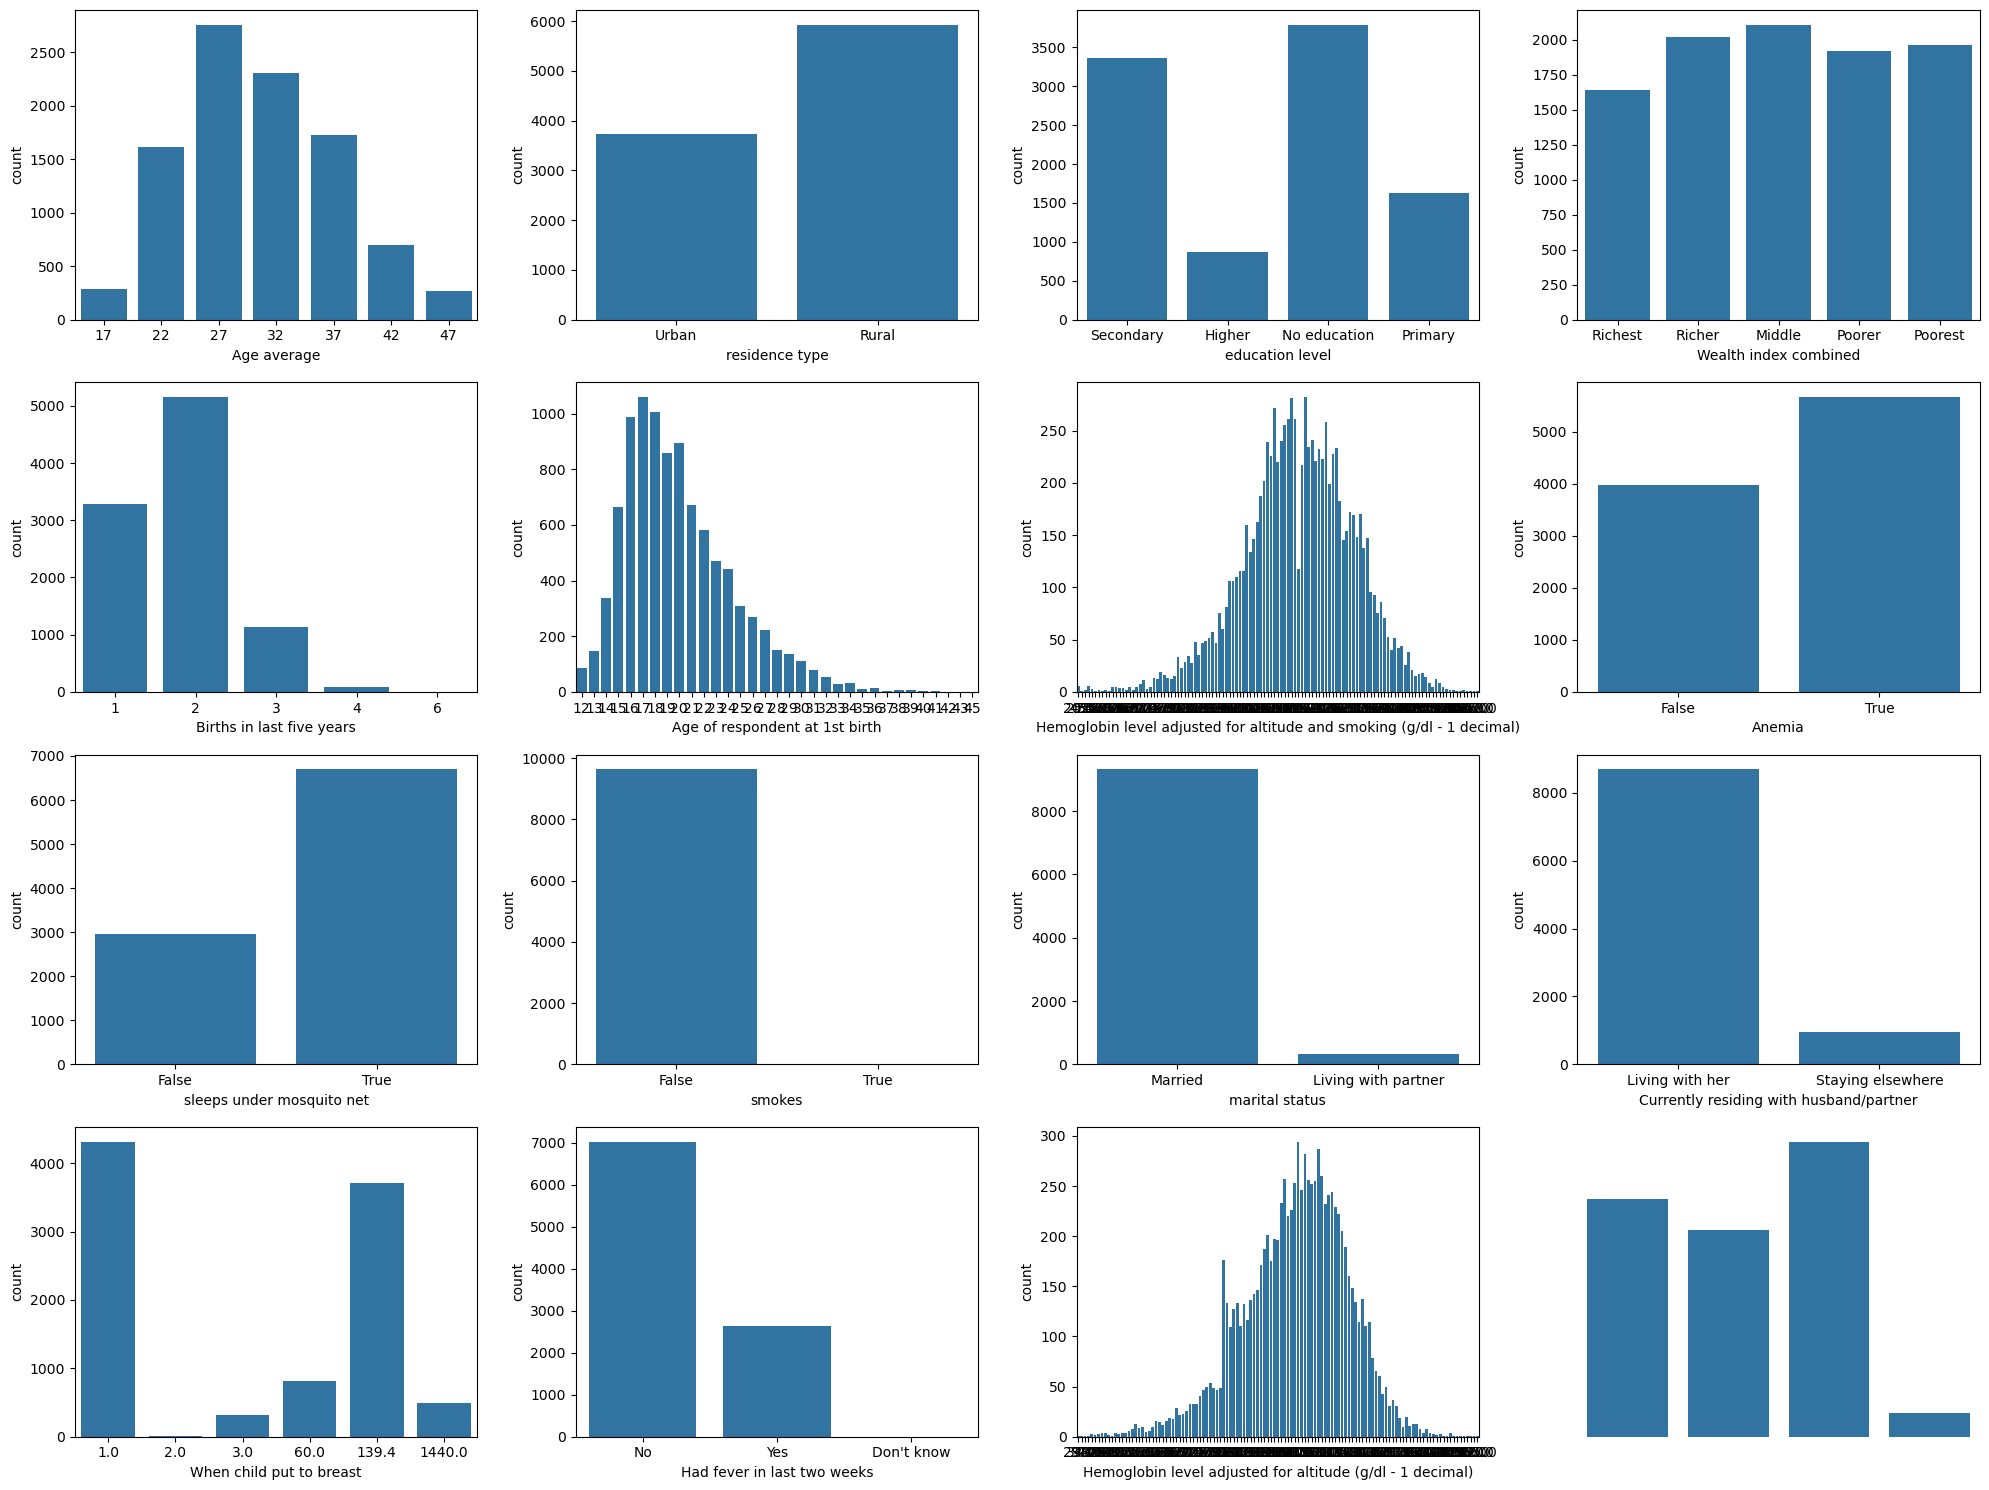

In [ ]:
fig,axes = plt.subplots(4,4, figsize = (20,15))
axes = axes.flatten()
axes[-1].axis('off')
for col,ax in zip(data_non.columns,axes):
    sns.countplot(data_non, x = col, ax = ax)
    value_count = data_non[col].value_counts()
plt.tight_layout()

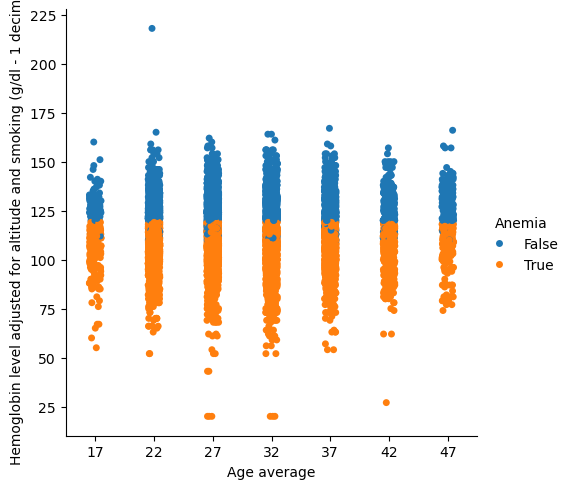

In [ ]:
sns.catplot(data=data_non,x='Age average',y='Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)',hue='Anemia')

In [ ]:
# Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal) is a strong factor 
# as it shows if a person will have Anemia or not

<Axes: xlabel='Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)', ylabel='Hemoglobin level adjusted for altitude (g/dl - 1 decimal)'>

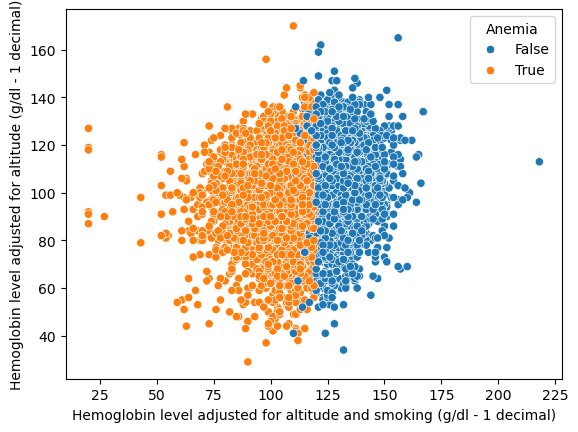

In [ ]:
sns.scatterplot(data=data_non,x='Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)',y='Hemoglobin level adjusted for altitude (g/dl - 1 decimal)',hue='Anemia')

In [ ]:
# check Anemia values proportion
data_non['Anemia'].value_counts(normalize=True)

Anemia
True     0.587071
False    0.412929
Name: proportion, dtype: float64

In [ ]:
data_non.dtypes

Age average                                                                int32
residence type                                                            object
education level                                                           object
Wealth index combined                                                     object
Births in last five years                                                  int64
Age of respondent at 1st birth                                             int64
Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)    float64
Anemia                                                                      bool
sleeps under mosquito net                                                   bool
smokes                                                                      bool
marital status                                                            object
Currently residing with husband/partner                                   object
When child put to breast    

## MODEL

In [ ]:
num_cols = ['Births in last five years','Hemoglobin level adjusted for altitude (g/dl - 1 decimal)','Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)','Age of respondent at 1st birth']
cat_cols = [col for col in data_non.columns if col not in num_cols and col not in ['Anemia','Anemia level.1']]
cat_cols

['Age average',
 'residence type',
 'education level',
 'Wealth index combined',
 'sleeps under mosquito net',
 'smokes',
 'marital status',
 'Currently residing with husband/partner',
 'When child put to breast',
 'Had fever in last two weeks',
 'takes supplements',
 'avg_child_year']

In [ ]:
le = LabelEncoder()
ss = StandardScaler()

In [ ]:
# variables for data modelling
X = data_non.drop(['Anemia','Anemia level.1'], axis = 1)
y = le.fit_transform(data_non['Anemia'])

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state = 12, stratify=y)

In [ ]:
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
num_transformer = make_pipeline(StandardScaler())
preprocessor = ColumnTransformer([('categories',cat_transformer, cat_cols),('numerical',num_transformer,num_cols)])

In [ ]:
models = {'rf':RandomForestClassifier(),'log_regression':LogisticRegression(),'knn':KNeighborsClassifier()}

In [ ]:
model_res = {}
for name,model in models.items():
    pipe = Pipeline([('preprocessor', preprocessor),(name,model)]) 
    model_res[name] = pipe.fit(X_train,y_train)
    print(f"{model} done !")

In [ ]:
for name,model in model_res.items():
    print(f'{name:20s}: {model.score(X_test,y_test)}')

In [ ]:
y_pred = model_res['rf'].predict(X_test)

In [ ]:
cm_rf = confusion_matrix(y_test,y_pred)

In [ ]:
param_grid = {
    'estimator__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'estimator__max_depth': [10, 20, 30],  # Maximum depth of the tree
    'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'estimator__bootstrap': [True, False]  # Method for sampling data points
}
grid_pipe = Pipeline([('preprocessor',preprocessor),('estimator',RandomForestClassifier(random_state=11))])
rf_grid = GridSearchCV(grid_pipe, param_grid=param_grid,n_jobs=-1,cv=5, error_score='raise')
rf_grid.fit(X_train,y_train)

In [ ]:
rf_grid.score(X_test,y_test)

In [ ]:
best_rf_grid = rf_grid.best_estimator_[1].get_params()

In [ ]:
rf_pipe = make_pipeline(preprocessor,RandomForestClassifier(**best_rf_grid))
rf_pipe.fit(X_train,y_train)

In [ ]:
y_pred = rf_pipe.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test,y_pred)

In [ ]:
sns.heatmap(cm, annot = True,fmt = 'd',xticklabels= le.classes_, yticklabels= le.classes_, cmap=sns.color_palette("plasma"),linecolor='green',linewidths=.5)
plt.title('Confusion Matrix of Children Anemic Level Model')
plt.ylabel('True Label')
plt.xlabel('Prediction Label')
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
feature_names = [x.split('__')[1] for x in preprocessor.get_feature_names_out()]

In [ ]:
rf_model_step = rf_pipe.steps[1][1]
feat_imp = pd.DataFrame({'feature':feature_names, 'importances':rf_model_step.feature_importances_}).sort_values(by='importances', ascending=False)
feat_imp

In [ ]:
sns.barplot(data = feat_imp.iloc[:10],y= 'feature', x='importances').set_title('Top10 Feature Importances')